# ⚖️ Class Imbalance Analysis: Deep Dive into Data Balance

Welcome to our **Class Imbalance Analysis**! 🎯 This is where we become data detectives, investigating the balance (or imbalance) in our target variable and learning advanced techniques to handle it.

## 🔍 What is Class Imbalance?

Imagine a medical test where 99% of people are healthy and only 1% have a disease. If our model just predicts "healthy" for everyone, it gets 99% accuracy! But it completely fails at its actual job - detecting the disease. 😰

### 🎯 **Real-World Examples:**
- **📧 Email Spam**: 95% normal emails, 5% spam
- **🏥 Medical Diagnosis**: 99% healthy, 1% disease cases  
- **💳 Fraud Detection**: 99.9% legitimate, 0.1% fraudulent
- **👥 Employee Attrition**: 85% stay, 15% leave

## 📚 What We'll Master Today:

### 🔍 **Imbalance Detection & Analysis**
- Measure imbalance severity
- Understand impact on model performance  
- Visualize class distributions
- Identify which classes are problematic

### 🛠️ **Advanced Balancing Techniques**
- **SMOTE** variants (BorderlineSMOTE, ADASYN)
- **Undersampling** methods (EditedNearestNeighbours, Tomek Links)
- **Ensemble** methods (BalancedRandomForest)
- **Cost-sensitive** learning

### 📊 **Evaluation Strategies**
- Metrics that matter for imbalanced data
- Precision, Recall, F1-Score deep dive
- ROC-AUC vs PR-AUC comparison
- Confusion matrix interpretation

### 🎛️ **Strategy Selection**
- When to use each technique
- Combining multiple approaches
- Domain-specific considerations

---

## 🚀 Why This Matters

By the end of this notebook, you'll:
- ✅ **Detect imbalance** like a pro
- ✅ **Choose the right strategy** for your data
- ✅ **Apply advanced techniques** beyond basic SMOTE
- ✅ **Evaluate properly** using appropriate metrics
- ✅ **Build robust models** that work in real-world scenarios

Let's dive deep into the world of balanced machine learning! 🏊‍♂️

In [1]:
# 📦 Step 1: Import Libraries for Advanced Imbalance Analysis
print("📦 IMPORTING ADVANCED IMBALANCE LIBRARIES...")
print("="*45)

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set up beautiful plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Advanced imbalance-learn library techniques
from imblearn.over_sampling import (
    SMOTE,              # Standard SMOTE
    BorderlineSMOTE,    # Borderline cases SMOTE
    ADASYN,             # Adaptive Synthetic Sampling
    SVMSMOTE            # SVM-based SMOTE
)

from imblearn.under_sampling import (
    EditedNearestNeighbours,  # Remove noisy samples
    TomekLinks,               # Remove Tomek link pairs
    RandomUnderSampler,       # Random undersampling
    NeighbourhoodCleaningRule # Clean overlapping samples
)

from imblearn.combine import (
    SMOTETomek,         # SMOTE + Tomek links
    SMOTEENN            # SMOTE + Edited Nearest Neighbours
)

# Ensemble methods for imbalanced data
from imblearn.ensemble import (
    BalancedRandomForestClassifier,
    BalancedBaggingClassifier,
    EasyEnsembleClassifier
)

# Evaluation metrics for imbalanced data
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)

# Model selection and validation
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Utilities
from collections import Counter
from pathlib import Path
import sys

# 📁 Step 2: Set up project paths
print("\n📁 SETTING UP PROJECT PATHS...")
print("="*30)

current_dir = Path.cwd()
project_root = current_dir.parent
src_path = project_root / 'src'
sys.path.append(str(src_path))

print(f"📂 Project root: {project_root}")
print(f"📂 Data directory: {project_root / 'data'}")
print(f"📂 Processed data: {project_root / 'data' / 'processed'}")

# Constants
RANDOM_STATE = 42
print(f"\n🎲 Random state: {RANDOM_STATE}")
print("✅ Advanced imbalance analysis setup complete!")

📦 IMPORTING ADVANCED IMBALANCE LIBRARIES...

📁 SETTING UP PROJECT PATHS...
📂 Project root: c:\Users\DELL\Desktop\AI-Project\AI-Project
📂 Data directory: c:\Users\DELL\Desktop\AI-Project\AI-Project\data
📂 Processed data: c:\Users\DELL\Desktop\AI-Project\AI-Project\data\processed

🎲 Random state: 42
✅ Advanced imbalance analysis setup complete!


## 📊 Step 1: Load Data and Detect Imbalance

Let's start by loading our processed data from the feature engineering notebook and conducting a thorough imbalance analysis.

### 🔍 **What We'll Analyze:**
- **📈 Imbalance severity**: How bad is the imbalance?
- **📊 Class distribution**: Exact numbers and percentages
- **🎯 Impact assessment**: How will this affect our models?
- **📋 Baseline metrics**: What happens if we do nothing?

### 📏 **Imbalance Metrics:**
- **Imbalance Ratio**: Majority/Minority ratio
- **Minority Percentage**: % of minority class
- **Severity Level**: Critical, High, Moderate, or Low

In [2]:
# 📁 Step 1: Load processed data
print("📁 LOADING PROCESSED DATA...")
print("="*27)

# Try to load from processed data directory
processed_dir = project_root / 'data' / 'processed'
data_loaded = False

# Try to load feature engineered data
try:
    df_path = processed_dir / 'feature_engineered_data.csv'
    if df_path.exists():
        df = pd.read_csv(df_path)
        print(f"✅ Loaded feature engineered data: {df.shape}")
        data_loaded = True
    else:
        print("❌ Feature engineered data not found")
except Exception as e:
    print(f"❌ Error loading data: {e}")

# If processed data not available, try to load raw data
if not data_loaded:
    print("\n🔄 Trying to load raw data...")
    raw_data_paths = [
        project_root / 'data' / 'raw' / 'employee_data.csv',
        project_root / 'data' / 'employee_data.csv',
        project_root / 'employee_data.csv'
    ]
    
    for path in raw_data_paths:
        if path.exists():
            df = pd.read_csv(path)
            print(f"✅ Loaded raw data: {df.shape}")
            print("⚠️ Note: Using raw data - may need basic preprocessing")
            data_loaded = True
            break

if not data_loaded:
    print("❌ No data found. Please ensure data files are available.")
    df = None

# 🎯 Step 2: Identify target variable
if df is not None:
    print(f"\n🎯 IDENTIFYING TARGET VARIABLE...")
    print("="*32)
    
    # Look for common target variable names
    target_candidates = ['Attrition', 'attrition', 'Left', 'left', 'Turnover', 'turnover']
    target_col = None
    
    for col in df.columns:
        if col in target_candidates or any(candidate.lower() in col.lower() for candidate in target_candidates):
            target_col = col
            break
    
    # If not found, look for binary columns
    if target_col is None:
        binary_cols = [col for col in df.columns if df[col].nunique() == 2]
        if binary_cols:
            target_col = binary_cols[0]
            print(f"🔍 Using binary column as target: {target_col}")
    
    if target_col:
        print(f"✅ Target variable identified: '{target_col}'")
        
        # Get basic info about target
        target_values = df[target_col].value_counts()
        print(f"📊 Target values: {list(target_values.index)}")
        print(f"📋 Sample size: {len(df):,} records")
    else:
        print("❌ Could not identify target variable automatically")
        print("Available columns:", list(df.columns))

# 📊 Step 3: Comprehensive imbalance analysis
if df is not None and target_col:
    print(f"\n📊 COMPREHENSIVE IMBALANCE ANALYSIS")
    print("="*38)
    
    # Basic distribution
    target_counts = df[target_col].value_counts()
    target_percentages = df[target_col].value_counts(normalize=True) * 100
    
    print(f"🎯 Target variable: {target_col}")
    print(f"📊 Class distribution:")
    
    for value, count in target_counts.items():
        percentage = target_percentages[value]
        print(f"  • {value}: {count:,} samples ({percentage:.2f}%)")
    
    # Calculate imbalance metrics
    minority_class_pct = target_percentages.min()
    majority_class_pct = target_percentages.max()
    imbalance_ratio = majority_class_pct / minority_class_pct
    
    minority_count = target_counts.min()
    majority_count = target_counts.max()
    
    print(f"\n📏 IMBALANCE METRICS:")
    print(f"  • Minority class: {minority_class_pct:.2f}% ({minority_count:,} samples)")
    print(f"  • Majority class: {majority_class_pct:.2f}% ({majority_count:,} samples)")
    print(f"  • Imbalance ratio: {imbalance_ratio:.1f}:1")
    
    # Classify imbalance severity
    if imbalance_ratio >= 20:
        severity = "🔴 CRITICAL"
        impact = "Severe model bias expected"
        urgency = "Immediate balancing required"
    elif imbalance_ratio >= 10:
        severity = "🟠 HIGH"
        impact = "Significant model bias likely"
        urgency = "Strong balancing recommended"
    elif imbalance_ratio >= 4:
        severity = "🟡 MODERATE"
        impact = "Some model bias possible"
        urgency = "Balancing beneficial"
    else:
        severity = "🟢 LOW"
        impact = "Minimal bias expected"
        urgency = "Balancing optional"
    
    print(f"\n🚨 SEVERITY ASSESSMENT:")
    print(f"  • Level: {severity}")
    print(f"  • Impact: {impact}")
    print(f"  • Action: {urgency}")
    
    # Store important variables for later use
    minority_class = target_counts.idxmin()
    majority_class = target_counts.idxmax()
    
    print(f"\n📋 CLASS IDENTIFICATION:")
    print(f"  • Minority class: '{minority_class}' ({minority_count:,} samples)")
    print(f"  • Majority class: '{majority_class}' ({majority_count:,} samples)")

else:
    print("⚠️ Skipping imbalance analysis - data or target not available")

📁 LOADING PROCESSED DATA...
✅ Loaded feature engineered data: (11413, 28)

🎯 IDENTIFYING TARGET VARIABLE...
🔍 Using binary column as target: Work_accident
✅ Target variable identified: 'Work_accident'
📊 Target values: [0, 1]
📋 Sample size: 11,413 records

📊 COMPREHENSIVE IMBALANCE ANALYSIS
🎯 Target variable: Work_accident
📊 Class distribution:
  • 0: 9,682 samples (84.83%)
  • 1: 1,731 samples (15.17%)

📏 IMBALANCE METRICS:
  • Minority class: 15.17% (1,731 samples)
  • Majority class: 84.83% (9,682 samples)
  • Imbalance ratio: 5.6:1

🚨 SEVERITY ASSESSMENT:
  • Level: 🟡 MODERATE
  • Impact: Some model bias possible
  • Action: Balancing beneficial

📋 CLASS IDENTIFICATION:
  • Minority class: '1' (1,731 samples)
  • Majority class: '0' (9,682 samples)


## 🛠️ Step 2: Advanced SMOTE Techniques Comparison

Now let's explore **advanced SMOTE variants** beyond the basic SMOTE! Each technique has its strengths and is designed for different scenarios.

### 🔬 **SMOTE Variants We'll Test:**

#### 1️⃣ **Standard SMOTE**
- **What**: Creates synthetic samples between existing minority samples
- **Best for**: General use, balanced features
- **Pros**: Simple, widely tested, good baseline
- **Cons**: May create samples in noisy regions

#### 2️⃣ **BorderlineSMOTE** 
- **What**: Focuses on minority samples near the decision boundary
- **Best for**: When classes overlap significantly
- **Pros**: Creates more meaningful synthetic samples
- **Cons**: May miss some minority regions

#### 3️⃣ **ADASYN (Adaptive Synthetic)**
- **What**: Generates more synthetic data for harder-to-learn minority samples
- **Best for**: Complex decision boundaries
- **Pros**: Adaptive to data difficulty
- **Cons**: More complex, sensitive to noise

#### 4️⃣ **SVMSMOTE**
- **What**: Uses SVM to find support vectors for synthetic sample generation
- **Best for**: High-dimensional data
- **Pros**: Theoretically motivated approach
- **Cons**: Computationally expensive

### 📊 **Evaluation Strategy:**
- **Before/After visualization** of each technique
- **Class distribution** comparison
- **Sample quality** assessment
- **Performance impact** on simple classifiers

🛠️ PREPARING DATA FOR SMOTE COMPARISON...
📊 Features prepared:
  • Feature matrix (X): (11413, 14)
  • Target vector (y): (11413,)
  • Numerical features used: 14

📋 Original class distribution:
  • 0: 9,682 (84.8%)
  • 1: 1,731 (15.2%)

🔬 APPLYING SMOTE TECHNIQUES...

🔧 Testing Standard SMOTE...
  ✅ Success! Created 7,951 synthetic samples
     New distribution: {0: 9682, 1: 9682}

🔧 Testing BorderlineSMOTE...
  ✅ Success! Created 7,951 synthetic samples
     New distribution: {0: 9682, 1: 9682}

🔧 Testing ADASYN...
  ✅ Success! Created 7,905 synthetic samples
     New distribution: {0: 9682, 1: 9636}

🔧 Testing SVMSMOTE...
  ✅ Success! Created 7,951 synthetic samples
     New distribution: {0: 9682, 1: 9682}

📊 SMOTE TECHNIQUES COMPARISON:
Technique            Original   New Size   Synthetic  Status
-----------------------------------------------------------------
Standard SMOTE       11413      19364      7951       ✅ Success
BorderlineSMOTE      11413      19364      7951       ✅ S

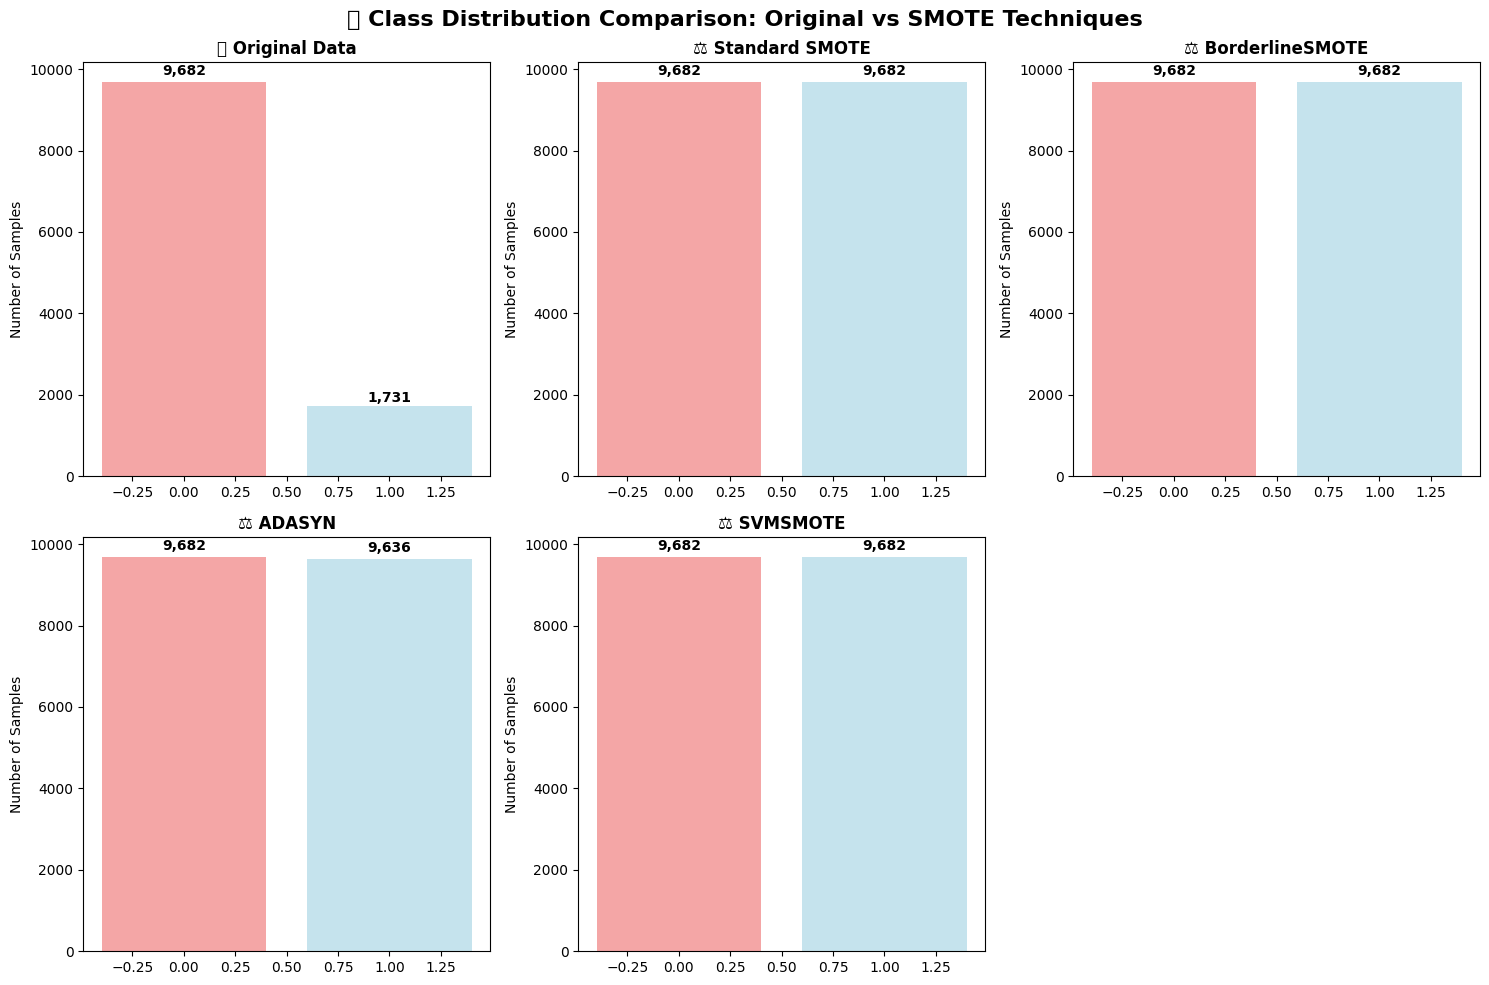

✅ Visualization complete!


In [3]:
# 🛠️ Step 1: Prepare data for SMOTE comparison
if df is not None and target_col:
    print("🛠️ PREPARING DATA FOR SMOTE COMPARISON...")
    print("="*40)
    
    # Prepare features (X) and target (y)
    # Use only numerical features for SMOTE (it works better with numbers)
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Remove target from features if it's numerical
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)
    
    X = df[numerical_cols]
    y = df[target_col]
    
    print(f"📊 Features prepared:")
    print(f"  • Feature matrix (X): {X.shape}")
    print(f"  • Target vector (y): {y.shape}")
    print(f"  • Numerical features used: {len(numerical_cols)}")
    
    # Show original class distribution
    original_distribution = Counter(y)
    print(f"\n📋 Original class distribution:")
    for class_val, count in original_distribution.items():
        percentage = (count / len(y)) * 100
        print(f"  • {class_val}: {count:,} ({percentage:.1f}%)")
    
    # 🔬 Step 2: Apply different SMOTE techniques
    print(f"\n🔬 APPLYING SMOTE TECHNIQUES...")
    print("="*32)
    
    # Dictionary to store results
    smote_results = {}
    
    # Define SMOTE techniques to test
    smote_techniques = {
        'Standard SMOTE': SMOTE(random_state=RANDOM_STATE),
        'BorderlineSMOTE': BorderlineSMOTE(random_state=RANDOM_STATE),
        'ADASYN': ADASYN(random_state=RANDOM_STATE),
        'SVMSMOTE': SVMSMOTE(random_state=RANDOM_STATE)
    }
    
    for name, technique in smote_techniques.items():
        print(f"\n🔧 Testing {name}...")
        
        try:
            # Apply the technique
            X_resampled, y_resampled = technique.fit_resample(X, y)
            
            # Store results
            new_distribution = Counter(y_resampled)
            smote_results[name] = {
                'X_resampled': X_resampled,
                'y_resampled': y_resampled,
                'distribution': new_distribution,
                'original_size': len(y),
                'new_size': len(y_resampled),
                'synthetic_created': len(y_resampled) - len(y)
            }
            
            print(f"  ✅ Success! Created {len(y_resampled) - len(y):,} synthetic samples")
            print(f"     New distribution: {dict(new_distribution)}")
            
        except Exception as e:
            print(f"  ❌ Failed: {str(e)}")
            smote_results[name] = None
    
    # 📊 Step 3: Compare results
    print(f"\n📊 SMOTE TECHNIQUES COMPARISON:")
    print("="*35)
    
    # Create comparison table
    print(f"{'Technique':<20} {'Original':<10} {'New Size':<10} {'Synthetic':<10} {'Status'}")
    print("-" * 65)
    
    for name, result in smote_results.items():
        if result is not None:
            original = result['original_size']
            new_size = result['new_size']
            synthetic = result['synthetic_created']
            status = "✅ Success"
        else:
            original = len(y)
            new_size = "Failed"
            synthetic = "Failed"
            status = "❌ Failed"
        
        print(f"{name:<20} {original:<10} {new_size:<10} {synthetic:<10} {status}")
    
    # 📈 Step 4: Visualize distributions
    print(f"\n📈 CREATING DISTRIBUTION VISUALIZATIONS...")
    print("="*38)
    
    # Count successful techniques for subplot arrangement
    successful_techniques = {name: result for name, result in smote_results.items() if result is not None}
    n_techniques = len(successful_techniques) + 1  # +1 for original
    
    # Create subplots
    fig, axes = plt.subplots(2, (n_techniques + 1) // 2, figsize=(15, 10))
    fig.suptitle('📊 Class Distribution Comparison: Original vs SMOTE Techniques', 
                 fontsize=16, fontweight='bold')
    
    # Flatten axes for easier indexing
    if n_techniques > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Plot original distribution
    ax = axes[0]
    original_counts = pd.Series(original_distribution)
    colors = ['lightcoral', 'lightblue']
    bars = ax.bar(original_counts.index, original_counts.values, color=colors, alpha=0.7)
    ax.set_title('📊 Original Data', fontweight='bold')
    ax.set_ylabel('Number of Samples')
    
    # Add value labels on bars
    for bar, count in zip(bars, original_counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Plot SMOTE results
    for i, (name, result) in enumerate(successful_techniques.items(), 1):
        ax = axes[i]
        smote_counts = pd.Series(result['distribution'])
        bars = ax.bar(smote_counts.index, smote_counts.values, color=colors, alpha=0.7)
        ax.set_title(f'⚖️ {name}', fontweight='bold')
        ax.set_ylabel('Number of Samples')
        
        # Add value labels
        for bar, count in zip(bars, smote_counts.values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01,
                    f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Hide empty subplots
    for i in range(n_techniques, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualization complete!")

else:
    print("⚠️ Skipping SMOTE comparison - data not available")